# Imports

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from random import sample
import os
from datetime import datetime, timedelta
from calendar import monthrange

import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
df = pd.read_csv('Shanghai_HMT_2010.csv')

In [3]:
df.sample(5)

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
9730,9731,2011,2,10,10,4,NaN,NaN,NaN,2.0,86.79,1022.0,4.0,NE,243.0,0.3,6.1
22262,22263,2012,7,16,14,2,NaN,34.0,NaN,21.0,58.65,1007.1,30.0,NE,9.0,0.0,0.0
36016,36017,2014,2,9,16,4,29.0,41.0,34.0,-2.0,74.78,1025.0,2.0,NE,65.0,0.0,0.0
32145,32146,2013,9,1,9,3,5.0,NaN,8.0,14.0,47.61,1013.0,26.0,NE,12.0,0.0,0.0
35665,35666,2014,1,26,1,4,86.0,71.0,96.0,2.0,70.47,1027.0,7.0,NE,64.0,0.0,0.0


In [4]:
df.shape

(52584, 17)

In [10]:
df[df.isna().any(axis=1)].shape

(31148, 17)

In [11]:
df.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015])

Не будем возиться с пустыми полями, просто удалим `Nan`. Оставшихся данных должно быть достаточно.

In [12]:
df.dropna(inplace=True)

# EDA

In [18]:
df.sample(10)

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
30905,30906,2013,7,11,17,2,54.0,41.0,59.0,21.0,41.91,1005.0,36.0,SE,16.0,0.0,0.0
37446,37447,2014,4,10,6,1,49.0,52.0,57.0,10.0,82.01,1018.0,13.0,NE,1.0,0.0,0.0
41227,41228,2014,9,14,19,3,15.0,19.0,11.0,19.0,69.40,1013.0,25.0,NE,177.0,0.0,0.0
40424,40425,2014,8,12,8,2,20.0,10.0,17.0,21.0,74.02,1005.0,26.0,NE,1.0,0.0,0.0
47859,47860,2015,6,18,3,2,11.0,10.0,12.0,20.0,94.03,1003.0,21.0,NE,54.0,2.2,3.3
43887,43888,2015,1,3,15,4,87.0,94.0,78.0,-5.0,30.09,1020.0,12.0,SW,5.0,0.0,0.0
44042,44043,2015,1,10,2,4,210.0,186.0,217.0,-1.0,74.96,1028.0,3.0,SW,3.0,0.0,0.0
36231,36232,2014,2,18,15,4,16.0,26.0,19.0,3.0,93.19,1024.0,4.0,NE,140.0,0.9,24.4
51344,51345,2015,11,10,8,3,88.0,85.0,90.0,8.0,81.75,1028.0,11.0,NW,310.0,0.0,0.0
30523,30524,2013,6,25,19,2,20.0,23.0,33.0,23.0,94.16,1000.0,24.0,NE,2.0,0.7,23.1


In [14]:
df = df.sort_values(by=['year', 'month', 'day', 'hour'])

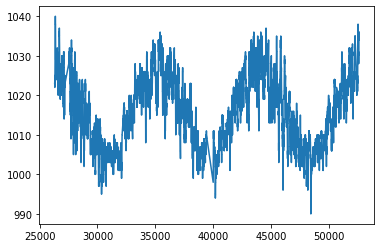

In [17]:
plt.plot(df.PRES)

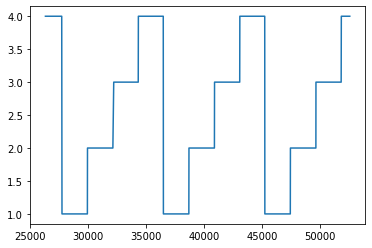

In [21]:
plt.plot(df.season)

Нужен ли нам признак `season`, если есть признак `month`?

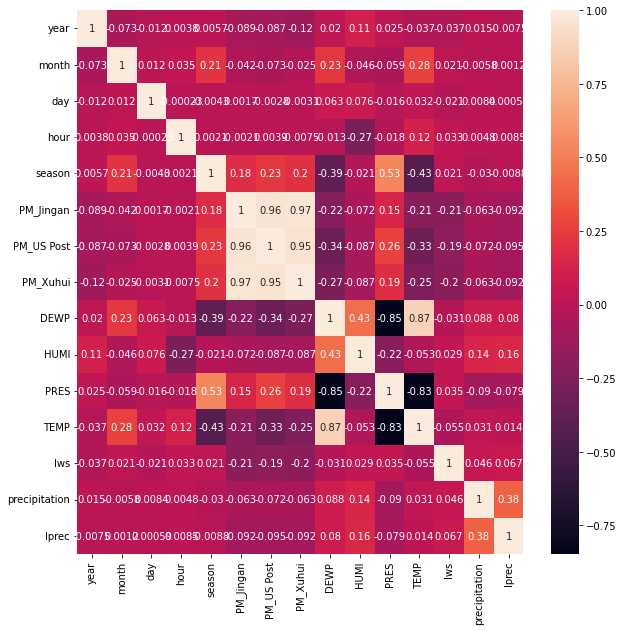

In [23]:
corr_cols = ['year', 'month', 'day', 'hour', 'season', 'PM_Jingan',
             'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws',
             'precipitation', 'Iprec']

plt.figure(figsize=(10, 10))
sns.heatmap(df[corr_cols].corr(method="pearson"), annot=True)
plt.show()

Видим, что таргет `PRES` сильнее всего коррелирует с признаками `DEWP` и `TEMP`.

# Feature encoding

- Временные признаки закодируем через sin и cos (кроме признака `season` -- его можно считать порядковым)
- Признак `cbwd` закодируем через TargetEncoder

In [36]:
df.hour.unique()

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23,  2, 12])

In [37]:
df['month_sin'] = np.sin(2 * np.pi * df.month / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df.month / 12.0)

df['hour_sin'] = np.sin(2 * np.pi * df.hour / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df.hour / 24.0)

df['day_of_month_sin'] = df.apply(lambda r: np.sin(2 * np.pi * r.day / monthrange(r.year, r.month)[1]),
                                  axis=1)
df['day_of_month_cos'] = df.apply(lambda r: np.cos(2 * np.pi * r.day / monthrange(r.year, r.month)[1]),
                                  axis=1)


Поделим на трейн и валидацию. Используем TS-validation

In [30]:
df.year.unique()

array([2013, 2014, 2015])

In [38]:
df_train = df[df.year < 2015]
df_val = df[df.year >= 2015]

In [39]:
df_train.shape, df_val.shape

((14587, 23), (6849, 23))

Закодируем признак `cbwd`

In [40]:
from category_encoders import (
    JamesSteinEncoder, 
    CatBoostEncoder, 
    TargetEncoder
)


In [41]:
ce_target = TargetEncoder(cols = ['cbwd'])

ce_target.fit(df_train.cbwd, df_train.PRES)

df_train['cbwd_te'] = ce_target.transform(df_train.cbwd).cbwd.values
df_val['cbwd_te'] = ce_target.transform(df_val.cbwd).cbwd.values

Нормализуем признаки

In [42]:
df_train.columns

Index(['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Jingan',
       'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws',
       'precipitation', 'Iprec', 'month_sin', 'month_cos', 'day_of_month_sin',
       'day_of_month_cos', 'hour_sin', 'hour_cos', 'cbwd_te'],
      dtype='object')

In [45]:
used_cols = ['year', 'month_sin', 'month_cos', 'day_of_month_sin',
             'day_of_month_cos', 'hour_sin', 'hour_cos', 
             'cbwd_te', 'season', 'PM_Jingan',
             'PM_US Post', 'PM_Xuhui', 'DEWP', 'HUMI', 'TEMP', 'Iws',
             'precipitation', 'Iprec']
target = 'PRES'

In [46]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df_train[used_cols])
x_val = sc.transform(df_val[used_cols])

# Model

## Train

In [47]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, df_train[target].values)

LinearRegression()

Посмотрим на feature importance:

In [52]:
for c, coef in zip(used_cols, list(reg.coef_)):
    print(f'{coef}\t{c}')

0.1100108550267566	year
-0.676136354826359	month_sin
3.2591848823314735	month_cos
-0.08723440662662975	day_of_month_sin
-0.17200886018948858	day_of_month_cos
0.19008181063062787	hour_sin
-0.33952427204800895	hour_cos
0.15771533781583613	cbwd_te
-0.5926919654221459	season
0.2667472611479349	PM_Jingan
-0.010391811417188016	PM_US Post
-0.8866424557311638	PM_Xuhui
4.008882704268326	DEWP
-3.753990560294437	HUMI
-9.632552178956901	TEMP
-0.16821684984972848	Iws
-0.14253423398689805	precipitation
-0.1586062649476858	Iprec


In [49]:
reg.intercept_

1016.1497909097142

## Evaluation

In [53]:
y_pred = reg.predict(x_val)

In [54]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
def report(y_true, y_pred):
    print('MSE:  {}'.format(mean_squared_error(y_true, y_pred)))
    print('MAE:  {}'.format(mean_absolute_error(y_true, y_pred)))
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_true, y_pred)))

In [55]:
report(df_val[target].values, y_pred)

MSE:  13.33775132910316
MAE:  2.8161580375771202
MAPE: 0.0027693951227232548


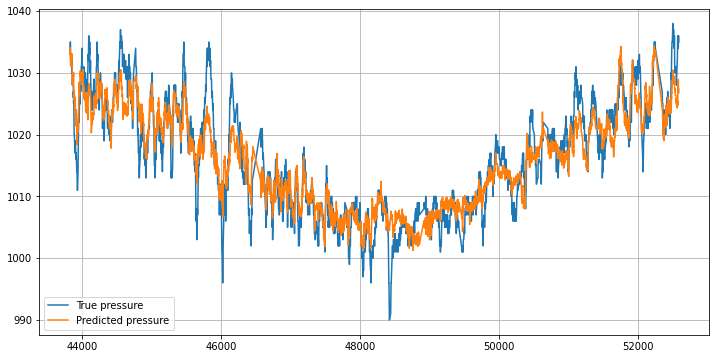

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(df_val.index, df_val.PRES, label='True pressure')
plt.plot(df_val.index, y_pred, label='Predicted pressure')
plt.legend()
plt.grid()
plt.show()

- Видим, что дисперсия предсказанных значений меньше.
- Достаточно неплохо предсказали давление (MAE = 2.8 hPa), не используя при этом никаких дополнительных признаков вроде скользящих окон.